# Study of COVID data in the US (based on NYT data)

In [184]:
import pandas as pd
import numpy as np
import matplotlib
import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sns
sns.set()
import time
import math

In [2]:
# matplotlib.style.use('seaborn-whitegrid')

## Get NYT data and prepare it

In [3]:
# Read from NYT data CSV
df_ = pd.read_csv('us-states.csv')

In [4]:
# Make date string a proper datetime data type
df_['date']=df_['date'].apply(lambda x:pd.Timestamp(x))
# Maje it a time series
# df_.set_index('date',inplace=True)
df_.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [5]:
# Add states abbreviations
df_abb = pd.read_csv('other_input/us-states-abbreviations.csv')
df = pd.merge(left=df_, right=df_abb, on='state', how='outer')
df.head()

,date,state,fips,cases,deaths,Abbreviation,Postal Code
0,2020-01-21,Washington,53,1,0,Wash.,WA
1,2020-01-22,Washington,53,1,0,Wash.,WA
2,2020-01-23,Washington,53,1,0,Wash.,WA
3,2020-01-24,Washington,53,1,0,Wash.,WA
4,2020-01-25,Washington,53,1,0,Wash.,WA


In [6]:
last_date = df.date.max()
last_date

Timestamp('2020-07-28 00:00:00')

## States ranked by number of cases

In [7]:
# States with most cases (on last available date)
df_ti = df[df['date'] == last_date].sort_values(by='cases', ascending=False)
# df_ti.set_index('date', inplace=True, drop=False)
df_ti.head()

,date,state,fips,cases,deaths,Abbreviation,Postal Code
562,2020-07-28,California,6,474951,8716,Calif.,CA
1889,2020-07-28,Florida,12,441969,6116,Fla.,FL
2039,2020-07-28,New York,36,417591,32333,N.Y.,NY
1269,2020-07-28,Texas,48,412744,6515,Tex.,TX
2782,2020-07-28,New Jersey,34,182215,15825,N.J.,NJ


Text(0.5, 1.0, 'Total number of cases per State (on July 28, 2020)')

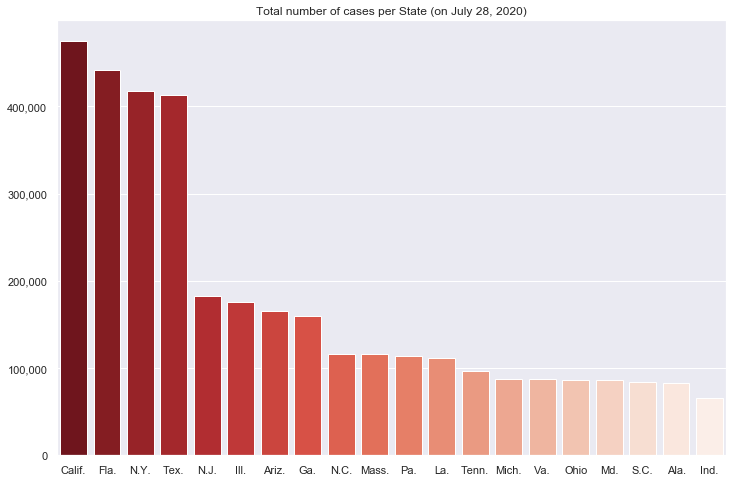

In [8]:
# Plot the States ranked by number of cases
fig, ax = plt.subplots(figsize=(12, 8))
number_of_states_to_visualize = 20
df_ti_p = df_ti.head(number_of_states_to_visualize).copy()
x = df_ti_p['Abbreviation']
y = df_ti_p['cases']
# bar_container = ax.bar(x=x, height=y)
sns.barplot(x=x, y=y, palette='Reds_r', ax=ax)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
ax.get_xaxis().label.set_visible(False)
ax.get_yaxis().label.set_visible(False)
ax.set_title(f'Total number of cases per State (on {last_date.strftime("%B %d, %Y")})')

In [9]:
# fig.savefig(f'output_visuals/Total_number_of_Cases_{last_date.strftime("%B_%d_%Y")}.png')

## Evolution of number of cases per state

In [10]:
# Number of states considered (among top impacted)
nb_states_time_plot = 10
df_states_considered = df_ti['state'].head(nb_states_time_plot)
# index on the most impacted states only
boolean_index = df['state'].isin(df_states_considered)
# df time plot
df_tp = df[boolean_index]
df_tp.tail()

,date,state,fips,cases,deaths,Abbreviation,Postal Code
2778,2020-07-24,New Jersey,34,180265,15765,N.J.,NJ
2779,2020-07-25,New Jersey,34,180778,15776,N.J.,NJ
2780,2020-07-26,New Jersey,34,181283,15787,N.J.,NJ
2781,2020-07-27,New Jersey,34,181732,15804,N.J.,NJ
2782,2020-07-28,New Jersey,34,182215,15825,N.J.,NJ


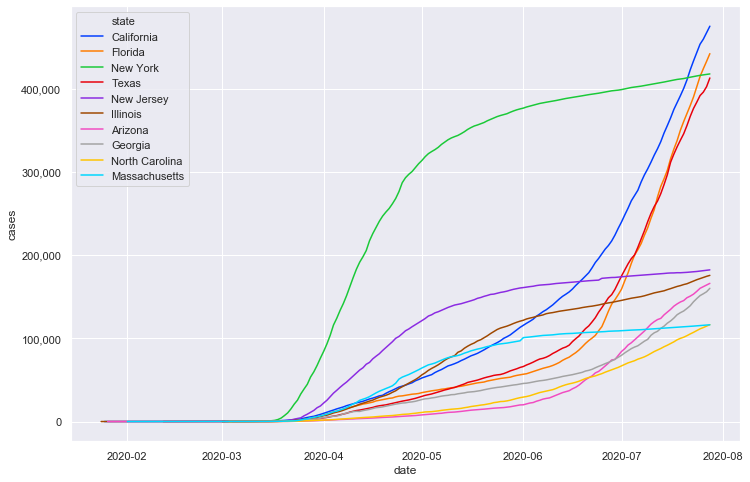

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x='date', y='cases', hue='state', palette='bright', hue_order=df_states_considered,
             ax=ax, data=df_tp)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))

In [12]:
fig.savefig(f'output_visuals/Evolution_total_number_of_cases_through_time_' \
            f'{last_date.strftime("%B_%d_%Y")}.png')

## Masks Effectiveness

In [13]:
# Initiate dfm dataframe to do that mask correlation analysis (cases per county through time)
dfm0 = pd.read_csv('us-counties.csv')
# Cast date into proper datetime objects
dfm0['date'] = dfm0['date'].apply(lambda x: pd.Timestamp(x))
dfm0.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [14]:
len(dfm0)

379550

###  Prepare and standardize the counties fips codes for use as a key for later merge

In [15]:
# fips dtype
# dfm0.fips.dtype

In [102]:
def fipsAsString(fips_float):
    """Converts a fips code read as float into a properly formatted string"""
    try:
        fips_int = int(fips_float)
        fips_str = str(fips_int)
    except:
        fips_str = 'NA'
    return fips_str

In [103]:
# If the fips column is a flaot, convert it to a string (for use as a key later)
def convertFromTypeToStr(df, from_type):
    if df.dtype == from_type:
        df = df.apply(fipsAsString)
        df = df.astype('str')
        print('df converted to string')
    else:
        print(f'df dtype already: {df.dtypes}')
    return df

In [18]:
dfm0['fips'] = convertFromTypeToStr(df=dfm0['fips'], from_type=np.float64)
# fips are now properly formatted as strings in the main dfm
dfm0.head(1)

df converted to string


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0


In [19]:
set(dfm0[dfm0['fips']==""].county)

{'Joplin', 'Kansas City', 'New York City', 'Unknown'}

In [20]:
len(dfm0)

379550

In [21]:
# For now, droppping counties without fip (may have to change that in the future,
# because dropping NYC)
dfm0 = dfm0[dfm0.fips != '']
len(dfm0)

375734

In [22]:
# Create the target dfm
dfm = dfm0.loc[:, ['fips', 'county', 'state']].copy()
dfm.drop_duplicates(subset='fips', inplace=True)
dfm['new_cases_m2w'] = np.nan
dfm.head()

,fips,county,state,new_cases_m2w
0,53061,Snohomish,Washington,NaN
3,17031,Cook,Illinois,NaN
5,6059,Orange,California,NaN
8,4013,Maricopa,Arizona,NaN
9,6037,Los Angeles,California,NaN


In [23]:
# Number of lines (counties)
len(dfm)

3187

### Calculate the average number of new cases per day per county on the last two weeks

In [24]:
# Calulate the new cases each day
dfm1 = dfm0.copy()
dfm1.sort_values(by='date', inplace=True)
# Only keep the last two keeks
time_condition = dfm1['date'].iloc[-1] - dfm1['date'] < pd.Timedelta(weeks=2)
dfm1 = dfm1[time_condition]
dfm1

,date,county,state,fips,cases,deaths
336809,2020-07-15,Grady,Oklahoma,40051,264,5
336808,2020-07-15,Garvin,Oklahoma,40049,140,3
336807,2020-07-15,Garfield,Oklahoma,40047,138,2
336802,2020-07-15,Creek,Oklahoma,40037,231,9
336805,2020-07-15,Dewey,Oklahoma,40043,4,0
...,...,...,...,...,...,...
377407,2020-07-28,Meade,Kentucky,21163,72,2
377408,2020-07-28,Menifee,Kentucky,21165,24,0
377409,2020-07-28,Mercer,Kentucky,21167,38,0
377411,2020-07-28,Monroe,Kentucky,21171,83,2


In [25]:
# Loop through the counties (using their fips) and compute mean of new cases on past two weeks
start_time = time.time()
for fips in dfm.fips:
    dfc = dfm1[dfm1.fips == fips].copy()
    dfc['new_cases'] = dfc.cases - dfc.cases.shift(1)
    fips_mean = dfc.new_cases.mean()
    dfm.loc[dfm.fips == fips, 'new_cases_m2w'] = fips_mean
print(f'Data processing time: {time.time() - start_time}')

Data processing time: 23.105840921401978


In [26]:
dfm

,fips,county,state,new_cases_m2w
0,53061,Snohomish,Washington,64.692308
3,17031,Cook,Illinois,521.461538
5,6059,Orange,California,600.153846
8,4013,Maricopa,Arizona,1920.230769
9,6037,Los Angeles,California,2741.000000
...,...,...,...,...
368310,30019,Daniels,Montana,0.000000
368434,31183,Wheeler,Nebraska,0.000000
369765,54017,Doddridge,West Virginia,0.333333
375990,49055,Wayne,Utah,0.000000


### Include the population per county (merge on county fips code)

In [27]:
# Read population csv
df_pop = pd.read_csv('other_input/us-county-population-census.csv', encoding='iso-8859-1')
df_pop.head(2)

,STATE,COUNTY,STNAME,CTYNAME,POPULATION
0,1,0,Alabama,Alabama,4903185
1,1,1,Alabama,Autauga County,55869


Need to create first a fips 'key' out of the STATE and COUNTY numbers, for later merge in main df:

In [28]:
# df_pop.dtypes

In [29]:
# Make STATE and COUNTY strings
df_pop['STATE'] = convertFromTypeToStr(df=df_pop['STATE'], from_type=np.int64)
df_pop['COUNTY'] = convertFromTypeToStr(df=df_pop['COUNTY'], from_type=np.int64)
# Zero padd the county (should be 3 digits)
df_pop['COUNTY'] = df_pop['COUNTY'].apply(lambda x: x.zfill(3))
# Create the county fips column in the population df
df_pop['fips'] = df_pop['STATE'] + df_pop['COUNTY']
# Drop unnecessary columns before merge
df_pop1 = df_pop.drop(columns=['STATE', 'COUNTY', 'STNAME'])
df_pop1.head(3)

df converted to string
df converted to string


,CTYNAME,POPULATION,fips
0,Alabama,4903185,1000
1,Autauga County,55869,1001
2,Baldwin County,223234,1003


In [30]:
# Merge the population data into the main df
dfm2 = pd.merge(left=dfm, right=df_pop1, on='fips', how='inner', left_index=True)
dfm2.drop(columns='CTYNAME', inplace=True)
dfm2.reset_index(inplace=True, drop=True)

In [31]:
dfm2

,fips,county,state,new_cases_m2w,POPULATION
0,53061,Snohomish,Washington,64.692308,822083
1,17031,Cook,Illinois,521.461538,5150233
2,6059,Orange,California,600.153846,3175692
3,4013,Maricopa,Arizona,1920.230769,4485414
4,6037,Los Angeles,California,2741.000000,10039107
...,...,...,...,...,...
3099,30019,Daniels,Montana,0.000000,1690
3100,31183,Wheeler,Nebraska,0.000000,783
3101,54017,Doddridge,West Virginia,0.333333,8448
3102,49055,Wayne,Utah,0.000000,2711


In [32]:
# Normalize the number of new cases with the population (per 100,000 habitants)
pop_basis = 100000
# m2wN : mean 2 weeks Normalized
dfm2['new_cases_m2wN'] = (dfm2['new_cases_m2w'] / dfm2['POPULATION']) * pop_basis
dfm2

,fips,county,state,new_cases_m2w,POPULATION,new_cases_m2wN
0,53061,Snohomish,Washington,64.692308,822083,7.869316
1,17031,Cook,Illinois,521.461538,5150233,10.125009
2,6059,Orange,California,600.153846,3175692,18.898364
3,4013,Maricopa,Arizona,1920.230769,4485414,42.810558
4,6037,Los Angeles,California,2741.000000,10039107,27.303225
...,...,...,...,...,...,...
3099,30019,Daniels,Montana,0.000000,1690,0.000000
3100,31183,Wheeler,Nebraska,0.000000,783,0.000000
3101,54017,Doddridge,West Virginia,0.333333,8448,3.945707
3102,49055,Wayne,Utah,0.000000,2711,0.000000


### Include percentage of mask use

In [379]:
# Import the use of mask and bucket FREQUENTLY and ALWAYS together
df_mu = pd.read_csv('mask-use/mask-use-by-county.csv')
df_mu.rename(columns={'COUNTYFP': 'fips'}, inplace=True)
df_mu.fips = convertFromTypeToStr(df=df_mu.fips, from_type=np.int64)
df_mu['mask_use'] = (df_mu['FREQUENTLY'] + df_mu['ALWAYS']) * 100
df_mu

df converted to string


,fips,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,mask_use
0,1001,0.053,0.074,0.134,0.295,0.444,73.9
1,1003,0.083,0.059,0.098,0.323,0.436,75.9
2,1005,0.067,0.121,0.120,0.201,0.491,69.2
3,1007,0.020,0.034,0.096,0.278,0.572,85.0
4,1009,0.053,0.114,0.180,0.194,0.459,65.3
...,...,...,...,...,...,...,...
3137,56037,0.061,0.295,0.230,0.146,0.268,41.4
3138,56039,0.095,0.157,0.160,0.247,0.340,58.7
3139,56041,0.098,0.278,0.154,0.207,0.264,47.1
3140,56043,0.204,0.155,0.069,0.285,0.287,57.2


In [33]:
df_mu.drop(columns=['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS'], inplace=True)
df_mu.head(3)

df converted to string


,fips,mask_use
0,1001,73.9
1,1003,75.9
2,1005,69.2


In [34]:
# Merge with main df
dfm3 = pd.merge(left=dfm2, right=df_mu, on='fips', how='inner', left_index=True)
# Rename the new cases column for convenience
dfm3.rename(columns={'new_cases_m2wN': 'new_cases', 'POPULATION': 'county_population'}, inplace=True)
dfm3.reset_index(inplace=True, drop=True)

In [35]:
# Complete df for mask use study
dfm3

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use
0,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2
1,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4
2,6059,Orange,California,600.153846,3175692,18.898364,91.0
3,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2
4,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7
...,...,...,...,...,...,...,...
3099,30019,Daniels,Montana,0.000000,1690,0.000000,39.8
3100,31183,Wheeler,Nebraska,0.000000,783,0.000000,60.0
3101,54017,Doddridge,West Virginia,0.333333,8448,3.945707,72.7
3102,49055,Wayne,Utah,0.000000,2711,0.000000,68.9


## New Cases | Use of Mask

In [36]:
# Scatter plot and correlation study
def myScatterPlot(df, save_name=None):
    """Scatter plot for covid mask use study"""
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.scatterplot(x='mask_use', y='new_cases', size='county_population', sizes=(10, 500),
                    data=df, ax=ax, alpha=0.9)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
    ax.get_xaxis().set_label_text('% of population wearing the mask frequently')
    ax.get_yaxis().set_label_text('new cases per day (per 100,000 caapita)')
    ax.legend(labelspacing=1.5)
    ax.set_title('Correlation between the number of new cases per 100,000 capita and the use of mask'\
                 '\nPer US county')
    if save_name:
        ax.get_figure().savefig('output_visuals/' + save_name, dpi=300)

In [37]:
# myScatterPlot(df=dfm3)

In [38]:
dfm3.describe()

,new_cases_m2w,county_population,new_cases,mask_use
count,3102.000000,3.104000e+03,3102.000000,3104.000000
mean,20.784323,1.030396e+05,16.831821,71.607764
std,104.620879,3.281160e+05,18.805614,13.084540
min,-12.076923,4.040000e+02,-6.597176,25.500000
25%,0.769231,1.123400e+04,4.991518,62.400000
50%,3.230769,2.621500e+04,10.776937,72.200000
75%,11.384615,6.857625e+04,22.446587,81.825000
max,2925.769231,1.003911e+07,266.980360,99.200000


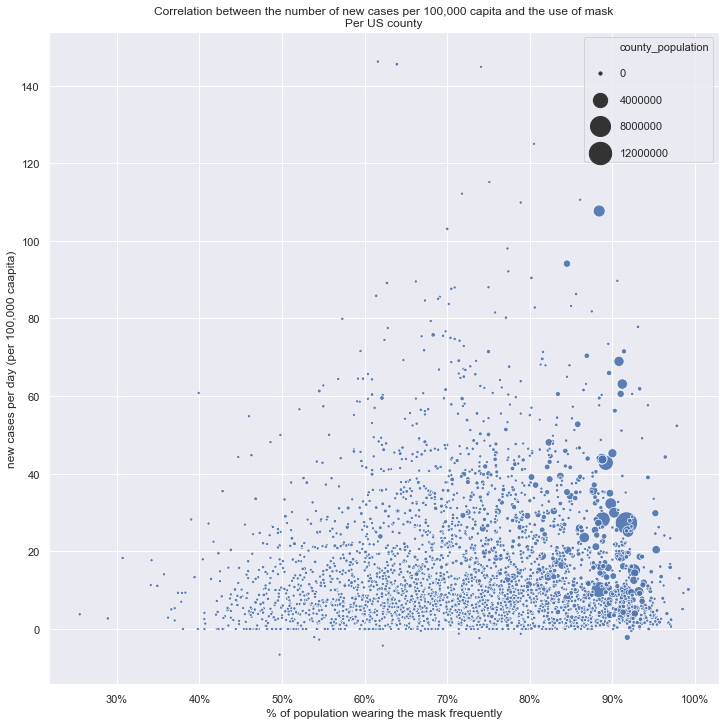

In [39]:
# Removing extreme cases
myScatterPlot(df=dfm3[dfm3.new_cases < 150], save_name=None)

The most populated counties tend to have the higher propency to wear masks (big disks on the right) while having a number of new cases p.h.t.c. being equal or higher than smaller (and potentially less dense) counties.

The percentage of population wearing a mask alone do not seem to be strongly correlated to the number of new cases p.h.t.c.. in a given county.

Next step will be to study the effect of the county density, which intuitively should be positively correlated to the number of new cases p.h.t.c..

*p.h.t.c. = per hundred thousand capita

## New Cases | Population Density

In [40]:
# Import the superficie of each county
dfa = pd.read_csv('other_input/LND01-census-land-area.csv')
dfa.drop(columns='Areaname', inplace=True)
dfa.rename(columns={'STCOU': 'fips', 'LND010200D': 'county_area'}, inplace=True)
dfa.fips = convertFromTypeToStr(df=dfa.fips, from_type=np.int64)
dfa.head(3)

df converted to string


,fips,county_area
0,0,3794083.06
1,1000,52419.02
2,1001,604.45


In [41]:
# Merge are in the main df
dfm4 = dfm3.copy()
dfm4 = pd.merge(left=dfm3, right=dfa, on='fips', how='inner', left_index=True)
# dfm4

In [42]:
# Calculate population density
dfm4['pop_density'] = dfm4.county_population / dfm4.county_area
dfm4.replace(np.inf, np.nan, inplace=True)
dfm4.head()

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,county_area,pop_density
3036,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,2196.41,374.284856
625,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4,1635.04,3149.912540
221,6059,Orange,California,600.153846,3175692,18.898364,91.0,947.98,3349.956750
107,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,9224.27,486.262219
210,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7,4752.32,2112.464438


In [43]:
# Plot new cases vs population density
def pop_density_plot(df, save_name=None):
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.scatterplot(x='pop_density', y='new_cases', size='county_population', sizes=(10, 500),
                    hue='mask_use', data=df, ax=ax, alpha=0.9)
    # ax.get_xaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
    ax.get_xaxis().set_label_text('county population density (people per square mile)')
    ax.get_yaxis().set_label_text('new cases per day (per 100,000 caapita)')
    ax.legend(labelspacing=1.5)
    ax.set_title('Correlation between the number of new cases per 100,000 capita '\
                 'and the population density\nPer US county')
    if save_name:
        ax.get_figure().savefig('output_visuals/' + save_name, dpi=300)

In [44]:
# pop_density_plot(df=dfm4)

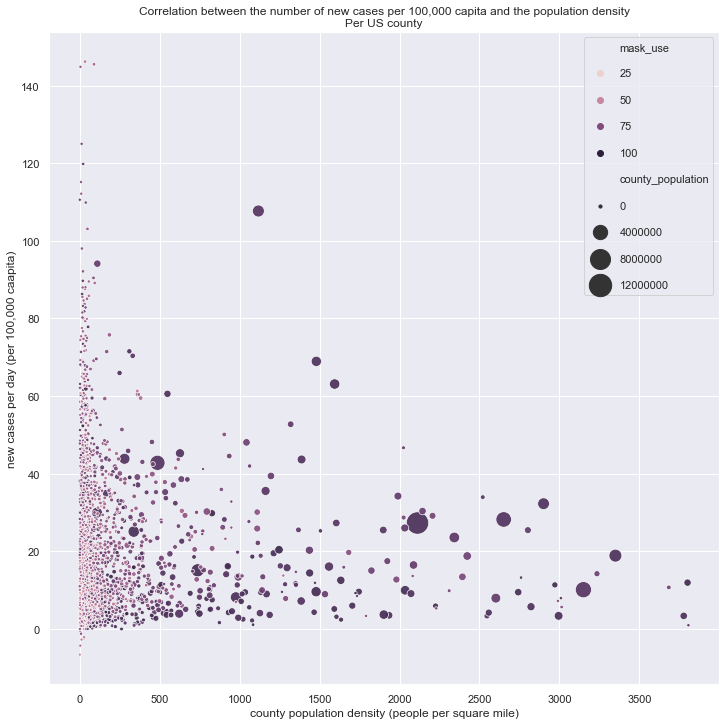

In [45]:
# Removing the extreme cases
pop_density_plot(df=dfm4[(dfm4.pop_density < 4000) & (dfm4.new_cases < 150)],
                 save_name='pop_density_dfm4.png')

## Mask-Use | Population Density

In [46]:
dfm4.head()

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,county_area,pop_density
3036,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,2196.41,374.284856
625,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4,1635.04,3149.912540
221,6059,Orange,California,600.153846,3175692,18.898364,91.0,947.98,3349.956750
107,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,9224.27,486.262219
210,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7,4752.32,2112.464438


In [47]:
def pop_density_mask_plot(df, save_name=None):
    """plots the mask use correlation to population density"""
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.scatterplot(x='pop_density', y='mask_use', size='county_population', sizes=(10, 500),
#                     hue='new_cases', 
                    data=df, ax=ax, alpha=1)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
    ax.get_xaxis().set_label_text('county population density (people per square mile)')
    ax.get_yaxis().set_label_text('% of people saying they wear the mask "frequently" or "always"')
    ax.legend(labelspacing=1.5)
    ax.set_title('Correlation between the population density '\
                 'and the use of mask\nPer US county')
    if save_name:
        ax.get_figure().savefig('output_visuals/' + save_name, dpi=300)
    return ax

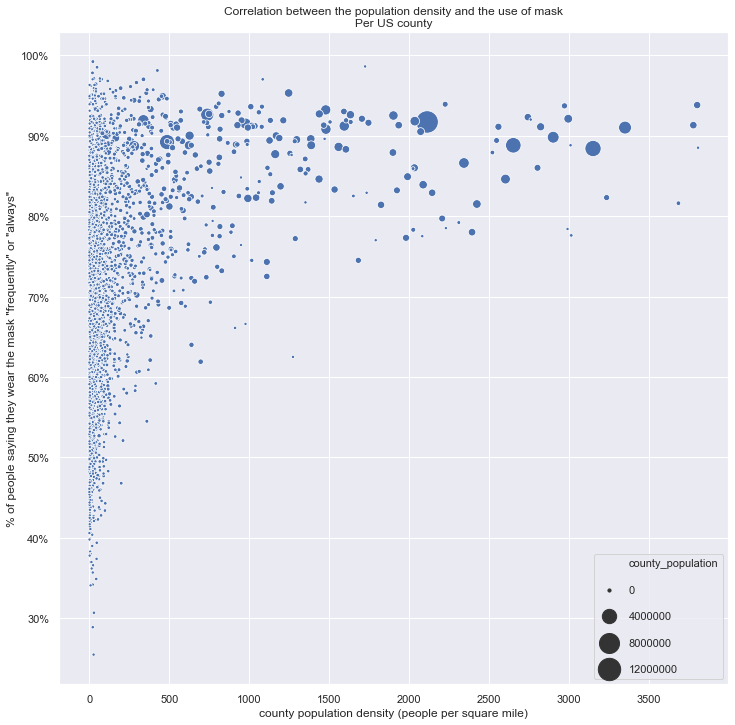

In [48]:
output_ax = pop_density_mask_plot(df=dfm4[(dfm4.pop_density < 4000) & (dfm4.new_cases < 100)], 
                     save_name='density_mask.png')

People living in high population density counties tend to consistently wear a mask.
People from lower density counties tend to be more distributed along the spectrum of mask usage.

In [49]:
output_ax.containers

[]

## Political | Mask-Use

### Get the political color of each county

In [283]:
dfp = pd.read_csv('other_input/countypres_2000-2016.csv')
dfp.drop(labels=dfp[dfp.year != 2016].index, inplace=True)
dfp.rename(columns={'FIPS': 'fips'}, inplace=True)
dfp.fips = convertFromTypeToStr(df=dfp.fips, from_type=np.float64)
dfp['party_perc'] = (dfp.candidatevotes / dfp.totalvotes) * 100
dfp.drop(labels=dfp[dfp.fips=='NA'].index, inplace=True) 
dfp2 = dfp.loc[:, ['fips', 'party', 'party_perc']].copy()
dfp2.head()

df converted to string


,fips,party,party_perc
40517,1001,democrat,23.769671
40518,1001,republican,72.766588
40519,1001,NaN,3.463741
40520,1003,democrat,19.385601
40521,1003,republican,76.545712


In [284]:
dfp3 = dfp2.pivot(index='fips', columns='party', values='party_perc')
dfp3.head()

party,NaN,democrat,republican
fips,,,
10001,5.705247,44.707633,49.587120
10003,5.315350,62.090163,32.594487
10005,3.833673,37.103803,59.062524
1001,3.463741,23.769671,72.766588
1003,4.068687,19.385601,76.545712


In [285]:
dfp3['maj_party'] = np.nan
dfp3.loc[dfp3[dfp3.democrat > dfp3.republican].index, 'maj_party'] = 'blue_state'
dfp3.loc[dfp3[dfp3.democrat < dfp3.republican].index, 'maj_party'] = 'red_state'
dfp3.head()

party,NaN,democrat,republican,maj_party
fips,,,,
10001,5.705247,44.707633,49.587120,red_state
10003,5.315350,62.090163,32.594487,blue_state
10005,3.833673,37.103803,59.062524,red_state
1001,3.463741,23.769671,72.766588,red_state
1003,4.068687,19.385601,76.545712,red_state


In [290]:
dfp3.loc['47041']

party
NaN              3.0913
democrat        22.5593
republican      74.3494
maj_party     red_state
Name: 47041, dtype: object

In [159]:
dfp3.drop(columns=[np.nan, 'democrat', 'republican'], inplace=True)
dfp3.head()

party,maj_party
fips,
10001,red_state
10003,blue_state
10005,red_state
1001,red_state
1003,red_state


In [164]:
# Merge the political color in the main df
dfm5 = pd.merge(left=dfm4, right=dfp3, on='fips', how='inner', left_index=True)
dfm5

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,county_area,pop_density,maj_party
2866,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,2196.41,374.284856,blue_state
360,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4,1635.04,3149.912540,blue_state
3054,6059,Orange,California,600.153846,3175692,18.898364,91.0,947.98,3349.956750,blue_state
1995,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,9224.27,486.262219,red_state
3043,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7,4752.32,2112.464438,blue_state
...,...,...,...,...,...,...,...,...,...,...
1398,30019,Daniels,Montana,0.000000,1690,0.000000,39.8,1426.52,1.184701,red_state
1536,31183,Wheeler,Nebraska,0.000000,783,0.000000,60.0,575.57,1.360391,red_state
2883,54017,Doddridge,West Virginia,0.333333,8448,3.945707,72.7,320.48,26.360459,red_state
2611,49055,Wayne,Utah,0.000000,2711,0.000000,68.9,2466.47,1.099142,red_state


### Add the political color to the plot

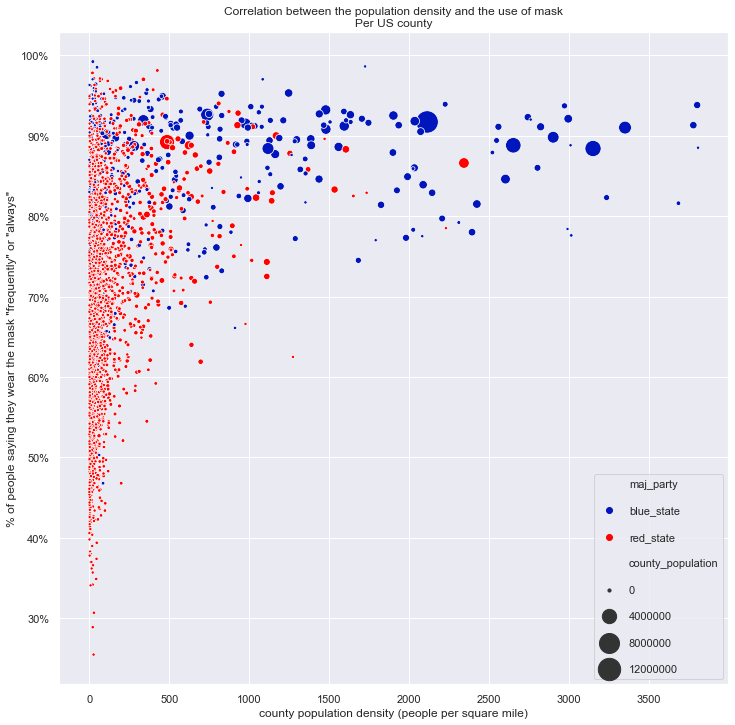

In [171]:
"""plots the mask use correlation to population density"""
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='pop_density', y='mask_use', size='county_population', sizes=(10, 500),
                hue='maj_party', 
                palette=['#0015BC', '#FF0000'],
                data=dfm5[dfm5.pop_density < 4000], 
                ax=ax, alpha=1)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
ax.get_xaxis().set_label_text('county population density (people per square mile)')
ax.get_yaxis().set_label_text('% of people saying they wear the mask "frequently" or "always"')
ax.legend(labelspacing=1.5)
ax.set_title('Correlation between the population density '\
             'and the use of mask\nPer US county')
ax.get_figure().savefig('output_visuals/' + 'Population-density_Mask-use_Political-color.png', dpi=300)

### Represent as a boxplot

In [190]:
# Create the bins for population density
max_dens = dfm6.pop_density.max()
rounded_max_dens = math.ceil(max_dens / 1000) * 1000
pop_density_steps = 500
bins_buckets = np.arange(0, rounded_max_dens + pop_density_steps, 500)
bins_buckets

array([   0,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])

In [191]:
# Bucket the county population density into bins
dfm6 = dfm5.copy()
dfm6.drop(labels=dfm6[dfm6.pop_density > 4000].index, inplace=True)
pop_dens_bins = pd.cut(x=dfm6.pop_density, bins=bins_buckets)
dfm6['pop_density_bins'] = pop_dens_bins
dfm6

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,county_area,pop_density,maj_party,pop_density_bins
2866,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,2196.41,374.284856,blue_state,"(0, 500]"
360,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4,1635.04,3149.912540,blue_state,"(3000, 3500]"
3054,6059,Orange,California,600.153846,3175692,18.898364,91.0,947.98,3349.956750,blue_state,"(3000, 3500]"
1995,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,9224.27,486.262219,red_state,"(0, 500]"
3043,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7,4752.32,2112.464438,blue_state,"(2000, 2500]"
...,...,...,...,...,...,...,...,...,...,...,...
1398,30019,Daniels,Montana,0.000000,1690,0.000000,39.8,1426.52,1.184701,red_state,"(0, 500]"
1536,31183,Wheeler,Nebraska,0.000000,783,0.000000,60.0,575.57,1.360391,red_state,"(0, 500]"
2883,54017,Doddridge,West Virginia,0.333333,8448,3.945707,72.7,320.48,26.360459,red_state,"(0, 500]"
2611,49055,Wayne,Utah,0.000000,2711,0.000000,68.9,2466.47,1.099142,red_state,"(0, 500]"


Text(0.5, 1.0, 'Correlation between the population density and the use of mask\nPer US county')

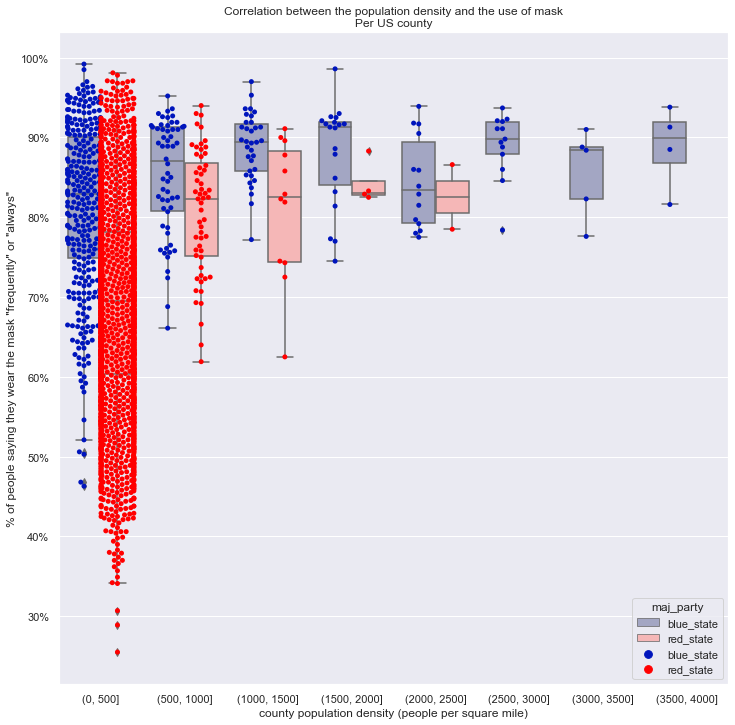

In [234]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.boxplot(x='pop_density_bins', y='mask_use', 
#             size='county_population', sizes=(10, 500),
            hue='maj_party', 
            palette=['#9da2c9', '#ffadad'],
#             palette=None,
            data=dfm6, 
            ax=ax)
sns.swarmplot(x='pop_density_bins', y='mask_use', 
#             size='county_population', sizes=(10, 500),
            hue='maj_party', 
            palette=['#0015BC', '#FF0000'],
#             palette='Reds',
            dodge=True,
            data=dfm6, 
            ax=ax)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
ax.get_xaxis().set_label_text('county population density (people per square mile)')
ax.get_yaxis().set_label_text('% of people saying they wear the mask "frequently" or "always"')
# ax.legend(labelspacing=1.5)
ax.set_title('Correlation between the population density '\
             'and the use of mask\nPer US county')

### Low population density counties

In [380]:
dfm7 = dfm6[dfm6.pop_density_bins == pd.Interval(0, 500, closed='right')]
dfm7.pop_density_bins = '[0-500]'
dfm7

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,county_area,pop_density,maj_party,pop_density_bins
2866,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,2196.41,374.284856,blue_state,[0-500]
1995,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,9224.27,486.262219,red_state,[0-500]
2942,55025,Dane,Wisconsin,50.307692,546695,9.202150,87.1,1238.32,441.481200,blue_state,[0-500]
3036,6023,Humboldt,California,3.538462,135558,2.610293,93.4,4052.22,33.452774,blue_state,[0-500]
3072,6095,Solano,California,75.461538,447643,16.857527,87.6,906.67,493.722082,blue_state,[0-500]
...,...,...,...,...,...,...,...,...,...,...,...
1398,30019,Daniels,Montana,0.000000,1690,0.000000,39.8,1426.52,1.184701,red_state,[0-500]
1536,31183,Wheeler,Nebraska,0.000000,783,0.000000,60.0,575.57,1.360391,red_state,[0-500]
2883,54017,Doddridge,West Virginia,0.333333,8448,3.945707,72.7,320.48,26.360459,red_state,[0-500]
2611,49055,Wayne,Utah,0.000000,2711,0.000000,68.9,2466.47,1.099142,red_state,[0-500]


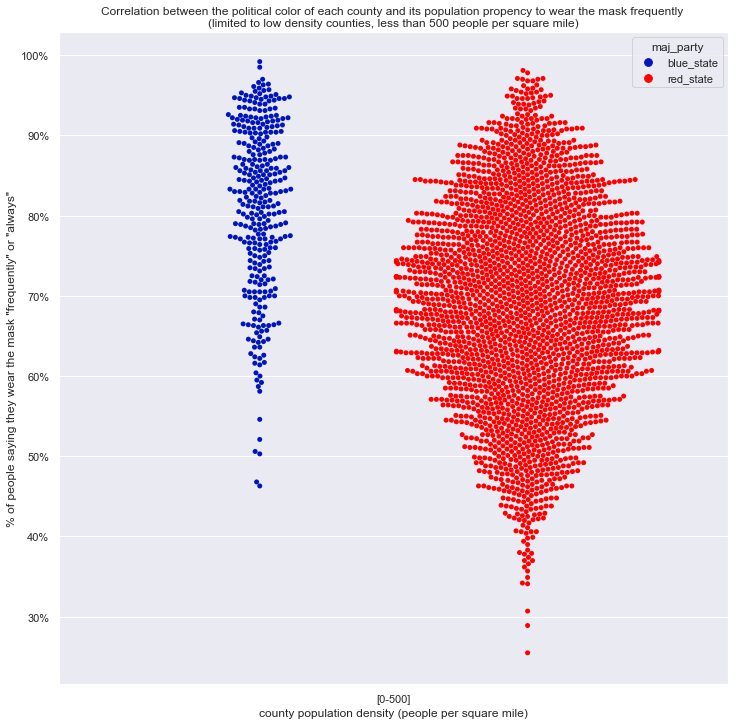

In [383]:
fig, ax = plt.subplots(figsize=(12, 12))
# sns.boxplot(x='pop_density_bins', y='mask_use', 
# #             size='county_population', sizes=(10, 500),
#             hue='maj_party', 
#             palette=['#9da2c9', '#ffadad'],
# #             palette=None,
#             data=dfm7, 
#             ax=ax)
sns.swarmplot(x='pop_density_bins', y='mask_use', 
#             size='county_population', sizes=(10, 500),
            hue='maj_party', 
            palette=['#0015BC', '#FF0000'],
#             palette='Reds',
            dodge=True,
            data=dfm7, 
            ax=ax)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
ax.get_xaxis().set_label_text('county population density (people per square mile)')
ax.get_yaxis().set_label_text('% of people saying they wear the mask "frequently" or "always"')
# ax.legend(labelspacing=1.5)
ax.set_title('Correlation between the political color of each county and its '\
             'population propency to wear'\
             ' the mask frequently \n(limited to low density counties, less than '\
             '500 people per square mile)')
ax.get_figure().savefig('output_visuals/' + 'Mask-use_Political_light-dens-co9unties.png', dpi=300)

FINIDING: In light population density counties (0 to 500 habitants per square mile), people are wearing the mask significantly more frequently in the democrat counties (compared to the republican counties).

## Shame Counties

In [278]:
dfm7[(dfm7.mask_use < 50) & (dfm7.new_cases > 40)]

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,county_area,pop_density,maj_party,pop_density_bins
2255,47041,DeKalb,Tennessee,11.230769,20490,54.810977,46.0,328.98,62.283421,red_state,[0-500]
16,1027,Clay,Alabama,6.615385,13235,49.984017,49.8,606.00,21.839934,red_state,[0-500]
632,19187,Webster,Iowa,16.076923,35904,44.777526,46.3,718.05,50.002089,red_state,[0-500]
573,19069,Franklin,Iowa,4.461538,10070,44.305248,44.7,583.01,17.272431,red_state,[0-500]
2254,47039,Decatur,Tennessee,5.615385,11663,48.147000,48.6,344.91,33.814618,red_state,[0-500]
1784,38005,Benson,North Dakota,4.153846,6832,60.799856,39.9,1439.27,4.746851,red_state,[0-500]


Counties with low mask-use (<50%), still having a way abover average number of new cases (> 40 new cases per day per 100,000 habitants, when the mean is 16)

## Mask-Use | Percentage of total population

In [371]:
dfm7 = dfm3.copy()
dfm7

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use
0,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2
1,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4
2,6059,Orange,California,600.153846,3175692,18.898364,91.0
3,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2
4,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7
...,...,...,...,...,...,...,...
3099,30019,Daniels,Montana,0.000000,1690,0.000000,39.8
3100,31183,Wheeler,Nebraska,0.000000,783,0.000000,60.0
3101,54017,Doddridge,West Virginia,0.333333,8448,3.945707,72.7
3102,49055,Wayne,Utah,0.000000,2711,0.000000,68.9


In [372]:
dfm7['pop_perc'] = (dfm7.county_population / dfm7.county_population.sum()) * 100
dfm7

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,pop_perc
0,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,0.257033
1,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4,1.610278
2,6059,Orange,California,600.153846,3175692,18.898364,91.0,0.992916
3,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,1.402415
4,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7,3.138840
...,...,...,...,...,...,...,...,...
3099,30019,Daniels,Montana,0.000000,1690,0.000000,39.8,0.000528
3100,31183,Wheeler,Nebraska,0.000000,783,0.000000,60.0,0.000245
3101,54017,Doddridge,West Virginia,0.333333,8448,3.945707,72.7,0.002641
3102,49055,Wayne,Utah,0.000000,2711,0.000000,68.9,0.000848


In [373]:
# Create mask-use bucketsj
mask_use_bins = np.arange(20, 110, 10)
dfm7['mask_use_buckets'] = pd.cut(x=dfm7.mask_use, bins=mask_use_bins)
dfm7

,fips,county,state,new_cases_m2w,county_population,new_cases,mask_use,pop_perc,mask_use_buckets
0,53061,Snohomish,Washington,64.692308,822083,7.869316,91.2,0.257033,"(90, 100]"
1,17031,Cook,Illinois,521.461538,5150233,10.125009,88.4,1.610278,"(80, 90]"
2,6059,Orange,California,600.153846,3175692,18.898364,91.0,0.992916,"(90, 100]"
3,4013,Maricopa,Arizona,1920.230769,4485414,42.810558,89.2,1.402415,"(80, 90]"
4,6037,Los Angeles,California,2741.000000,10039107,27.303225,91.7,3.138840,"(90, 100]"
...,...,...,...,...,...,...,...,...,...
3099,30019,Daniels,Montana,0.000000,1690,0.000000,39.8,0.000528,"(30, 40]"
3100,31183,Wheeler,Nebraska,0.000000,783,0.000000,60.0,0.000245,"(50, 60]"
3101,54017,Doddridge,West Virginia,0.333333,8448,3.945707,72.7,0.002641,"(70, 80]"
3102,49055,Wayne,Utah,0.000000,2711,0.000000,68.9,0.000848,"(60, 70]"


In [374]:
dfm7s = dfm7.loc[:, ['mask_use_buckets', 'pop_perc']]
dfm7s

,mask_use_buckets,pop_perc
0,"(90, 100]",0.257033
1,"(80, 90]",1.610278
2,"(90, 100]",0.992916
3,"(80, 90]",1.402415
4,"(90, 100]",3.138840
...,...,...
3099,"(30, 40]",0.000528
3100,"(50, 60]",0.000245
3101,"(70, 80]",0.002641
3102,"(60, 70]",0.000848


In [375]:
dfm7sg = dfm7s.groupby(by='mask_use_buckets').sum()
dfm7sg

,pop_perc
mask_use_buckets,
"(20, 30]",0.013659
"(30, 40]",0.073255
"(40, 50]",0.880558
"(50, 60]",3.187771
"(60, 70]",8.362238
"(70, 80]",17.798282
"(80, 90]",40.261378
"(90, 100]",29.422858


Text(0.5, 1.0, 'Breakdown of the US population per frequent mask-use %')

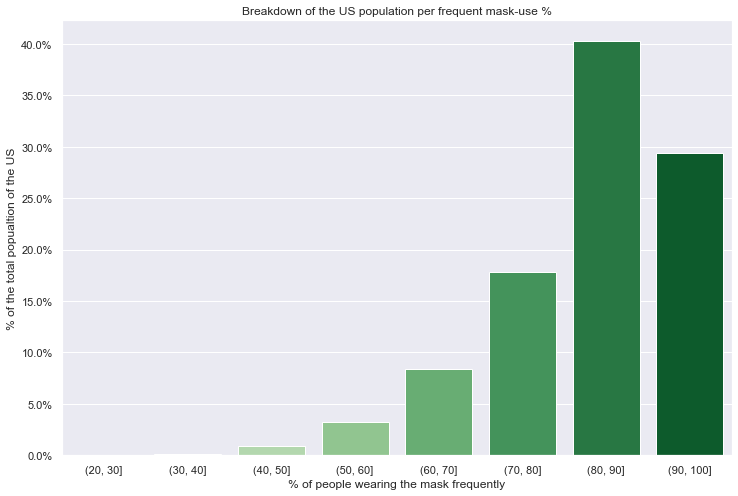

In [378]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=dfm7sg.index.values, y=dfm7sg.pop_perc, palette='Greens')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
ax.get_xaxis().set_label_text('% of people wearing the mask frequently')
ax.get_yaxis().set_label_text('% of the total popualtion of the US')
ax.set_title('Breakdown of the US population per frequent mask-use %')
# ax.get_figure().savefig('output_visuals/' + 'Mask-use_Political_light-dens-co9unties.png', dpi=300)

## Sates ranked per number of cases

In [50]:
last_timestamp = df.index.sort_values()[-1]

In [51]:

df[last_timestamp:].sort_values(by='cases',ascending=False).head(10)

,date,state,fips,cases,deaths,Abbreviation,Postal Code
8153,2020-07-28,Northern Mariana Islands,69,40,2,NaN,NaN


In [52]:
df_summary = df.loc[last_timestamp:, ['cases', 'deaths']].sum().copy()
df_summary.index.values

array(['cases', 'deaths'], dtype=object)

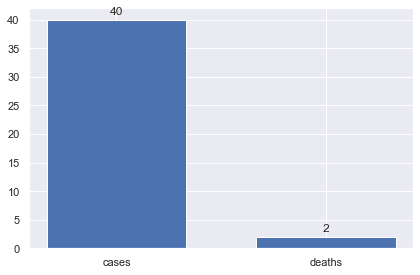

In [53]:
fig, ax = plt.subplots()
rects = ax.bar(x=[0, 0.3], height=df_summary.values, width=0.2, tick_label=df_summary.index.values)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,p: format(int(x),',')))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects)

fig.tight_layout()


### Mortality rate

In [54]:
df_summary['deaths'] / df_summary['cases']

0.05

## Number of New Cases per day (for a list of states)

In [55]:
states_list = ["New York","New Jersey","California","Michigan","Massachusetts","Florida","Washington","Illinois","Pennsylvania","Louisiana", "Texas"]

In [56]:
df_states_list = []

In [57]:
# Iterate over all states, create the df and append to the list
for i,state in enumerate(states_list):
    # create a local copy of the df
    df_state = df[df.state == state].copy()
    # calculate the number of new cases per day
    df_state['new cases'] = df_state['cases'] - df_state['cases'].shift(1)
    df_state.fillna(0,inplace=True)
    # calculate SMA
    df_state['SMA'] = ( df_state['new cases'] + df_state['new cases'].shift(1) + df_state['new cases'].shift(2) )*1/3
    # append the df of that state to the list
    df_states_list.append(df_state)

In [58]:
# df_states_list[0].tail()

### PLOT OF NEW CASES (for the 4 most impacted states)

In [59]:
def my_new_cases_plotter(df_list,states_list):

    nb_columns_fig = 2
    nb_rows_fig = 6
#     If more than 4 grapghs, extend the rows
#     if len(df_list) > 4:
#         nb_rows_fig = int((np.ceil(len(df_list) / nb_columns_fig)))
    
    fig, ax_arr = plt.subplots(nb_rows_fig, nb_columns_fig)  # create a figure with a 'rows x columns' grid of axes
    fig.set_size_inches(16,24)
    fig.suptitle("New cases registered per day")
    
    for df_index in range(len(df_list)):  # iterate over all the data frames to plot
    
        i_fig = int((np.floor(df_index / nb_columns_fig)))  # row position of the axes on that given figure
        j_fig = int((df_index % nb_columns_fig))  # column position of the axes on that given figure

        df = df_list[df_index].loc['20200301':]  # df to plot at that position

        ax_arr[i_fig,j_fig].bar(x=df['new cases'].index,height=df['new cases'],color="#900C3F")
        ax_arr[i_fig,j_fig].plot(df['new cases'].index,df['SMA'],color="#FFC300")

        ax_arr[i_fig,j_fig].xaxis.set_major_locator(WeekdayLocator(MONDAY))
#         ax_arr[i_fig,j_fig].xaxis.set_minor_locator(DayLocator())
        ax_arr[i_fig,j_fig].xaxis.set_major_formatter(DateFormatter('%d'))
#         ax_arr[i_fig,j_fig].xaxis.set_minor_formatter(DateFormatter('%d'))
        ax_arr[i_fig,j_fig].set_title(states_list[df_index])
    return fig
        

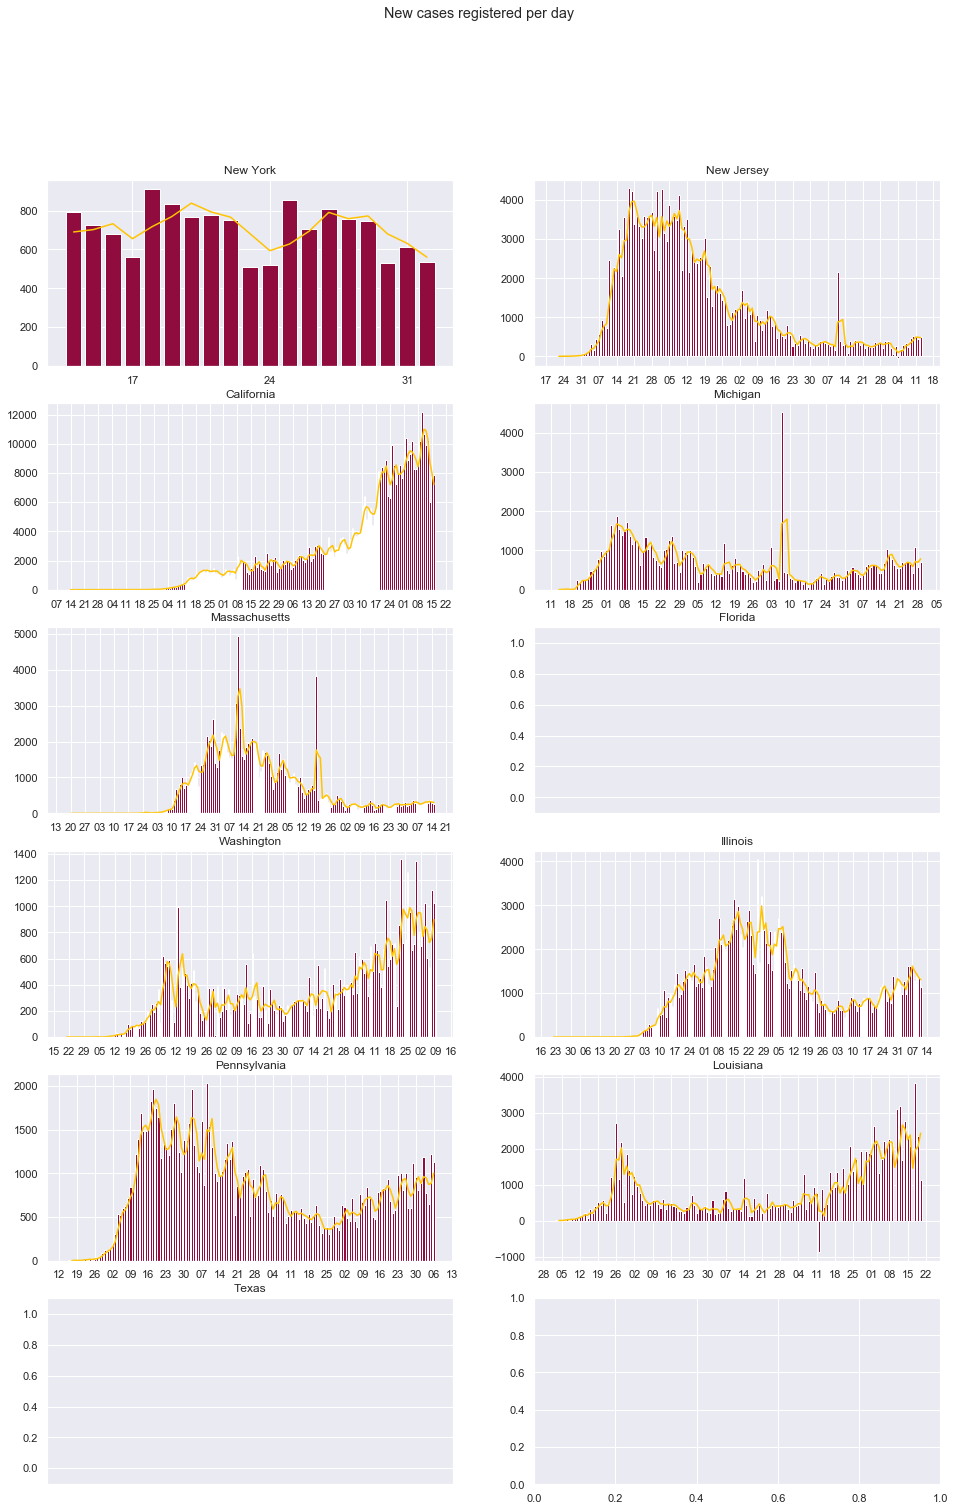

In [60]:
fig = my_new_cases_plotter(df_states_list,states_list)

In [61]:
# fig.savefig('covid_per_US_state.png')